In [33]:
import numpy as np
import pandas as pd
# import pandas_datareader as pdr Not working
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
#layers
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [34]:
#Reading in data and scaling it
import yfinance as yf

ticker = yf.Ticker("AMD")
start_date = dt.datetime(2005,1,1).strftime('%Y-%m-%d')
end_date = dt.datetime(2015,1,1).strftime('%Y-%m-%d')

data = ticker.history(start=start_date, end=end_date, interval='1d')

scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
scaled_data

array([[0.48660051],
       [0.45682382],
       [0.44540945],
       ...,
       [0.02133995],
       [0.02059554],
       [0.02158809]])

In [35]:
np.set_printoptions(threshold=3, linewidth=100)

timeSteps = 60

x_train = []
y_train = []

for i in range(timeSteps, len(scaled_data)):
    x_train.append(scaled_data[i-timeSteps:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape)
print(y_train.shape)
x_train

(2457, 60)
(2457,)


array([[0.48660051, 0.45682382, 0.44540945, ..., 0.33920598, 0.33796528, 0.35756823],
       [0.45682382, 0.44540945, 0.44466501, ..., 0.33796528, 0.35756823, 0.35533502],
       [0.44540945, 0.44466501, 0.44962781, ..., 0.35756823, 0.35533502, 0.35707199],
       ...,
       [0.0394541 , 0.03970224, 0.03870968, ..., 0.02158809, 0.02109182, 0.02109182],
       [0.03970224, 0.03870968, 0.03672457, ..., 0.02109182, 0.02109182, 0.02133995],
       [0.03870968, 0.03672457, 0.03672457, ..., 0.02109182, 0.02133995, 0.02059554]])

In [36]:
#reshape x_train for LSTM
x_train_reshaped = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print(x_train_reshaped.shape)
print(x_train_reshaped)

(2457, 60, 1)
[[[0.48660051]
  [0.45682382]
  [0.44540945]
  ...
  [0.33920598]
  [0.33796528]
  [0.35756823]]

 [[0.45682382]
  [0.44540945]
  [0.44466501]
  ...
  [0.33796528]
  [0.35756823]
  [0.35533502]]

 [[0.44540945]
  [0.44466501]
  [0.44962781]
  ...
  [0.35756823]
  [0.35533502]
  [0.35707199]]

 ...

 [[0.0394541 ]
  [0.03970224]
  [0.03870968]
  ...
  [0.02158809]
  [0.02109182]
  [0.02109182]]

 [[0.03970224]
  [0.03870968]
  [0.03672457]
  ...
  [0.02109182]
  [0.02109182]
  [0.02133995]]

 [[0.03870968]
  [0.03672457]
  [0.03672457]
  ...
  [0.02109182]
  [0.02133995]
  [0.02059554]]]


In [37]:
#Model

model = tf.keras.Sequential()


model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_reshaped.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #Prediction of closing value



model.compile(optimizer='adam', loss='mean_squared_error')


In [38]:
#Training

model.fit(x_train_reshaped, y_train, epochs=15, batch_size=64, verbose=1)

Epoch 1/15
39/39 [==============================] - 5s 36ms/step - loss: 0.0099
Epoch 2/15
39/39 [==============================] - 1s 36ms/step - loss: 0.0020
Epoch 3/15
39/39 [==============================] - 1s 35ms/step - loss: 0.0016
Epoch 4/15
39/39 [==============================] - 1s 35ms/step - loss: 0.0015
Epoch 5/15
39/39 [==============================] - 1s 34ms/step - loss: 0.0014
Epoch 6/15
39/39 [==============================] - 1s 34ms/step - loss: 0.0016
Epoch 7/15
39/39 [==============================] - 1s 34ms/step - loss: 0.0014
Epoch 8/15
39/39 [==============================] - 1s 35ms/step - loss: 0.0013
Epoch 9/15
39/39 [==============================] - 1s 36ms/step - loss: 0.0013
Epoch 10/15
39/39 [==============================] - 1s 36ms/step - loss: 0.0012
Epoch 11/15
39/39 [==============================] - 1s 36ms/step - loss: 0.0014
Epoch 12/15
39/39 [==============================] - 1s 35ms/step - loss: 0.0011
Epoch 13/15
39/39 [==================

In [39]:
#Testing

test_start = dt.datetime(2015,1,1).strftime('%Y-%m-%d')
test_end = dt.datetime.now().strftime('%Y-%m-%d')

test_data = ticker.history(start=test_start, end=test_end)

In [40]:
#Preparing test Data
y = test_data['Close'].values

df_whole = pd.concat((data['Close'], test_data['Close']), axis=0)


inputs = df_whole[len(df_whole) - len(test_data) - timeSteps:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [41]:
x_test = []
for i in range(timeSteps, len(inputs)):
    x_test.append(inputs[i-timeSteps:i, 0])

x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

69/69 [==============================] - 2s 9ms/step


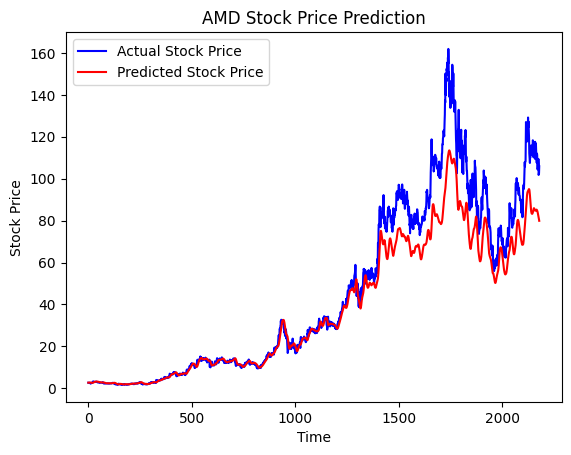

In [42]:
preictions = model.predict(x_test)
predictions = scaler.inverse_transform(preictions)


#Plotting
plt.plot(y, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')

plt.title(f'{ticker.info["symbol"]} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')

plt.legend()

plt.show()

In [43]:
#next day prediction

real_data = [inputs[len(inputs) - timeSteps:, 0]]
real_data = np.array(real_data)
real_data = real_data.reshape(real_data.shape[0], real_data.shape[1], 1)

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f'Prediction: {prediction}')

1/1 [==============================] - 0s 15ms/step
Prediction: [[79.457504]]


In [44]:
#predicting next 60 timeSteps

future_timeSteps = 60
predictions = []

for i in range(future_timeSteps):
    real_data = inputs[-timeSteps:]
    real_data = real_data.reshape(1,timeSteps, 1)

    prediction = model.predict(real_data)
    prediction = scaler.inverse_transform(prediction)

    #adding back new prediction to inputs
    inputs = np.append(inputs, prediction, axis=0)
    inputs = inputs[1:]

    predictions.append(prediction)

predictions = np.array(predictions)

predictions.shape

1/1 [==============================] - 0s 21ms/step


(60, 1, 1)

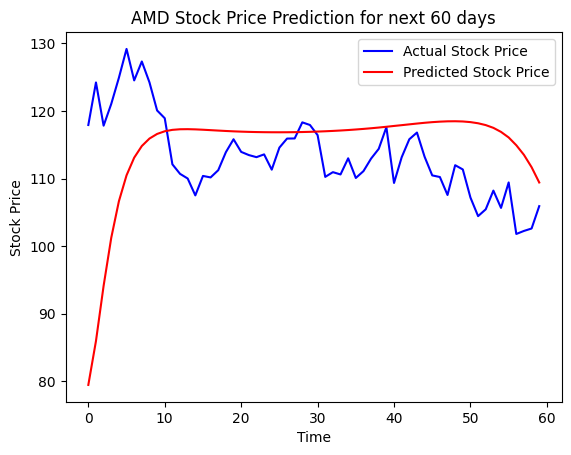

In [45]:
#plotting the predictions
real_values = test_data['Close'][-future_timeSteps:].values
predictions = predictions.reshape(-1)


plt.plot(real_values, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')

plt.title(f'{ticker.info["symbol"]} Stock Price Prediction for next {future_timeSteps} days')
plt.xlabel('Time')
plt.ylabel('Stock Price')

plt.legend()
plt.show()


In [46]:
#Sequence to Sequence Model
timeSteps = 60
future_timeSteps = 60


x_train_seq = []
y_train_seq = []

for i in range(timeSteps, len(scaled_data) - timeSteps - future_timeSteps):
    x_train_seq.append(scaled_data[i-timeSteps:i, 0])
    y_train_seq.append(scaled_data[i:i+future_timeSteps, 0])

x_train_seq, y_train_seq = np.array(x_train_seq), np.array(y_train_seq)


#Reshaping for LSTM
print(x_train_seq)
x_train_seq = x_train_seq.reshape(x_train_seq.shape[0], x_train_seq.shape[1], 1)
y_train_seq = y_train_seq.reshape(y_train_seq.shape[0], y_train_seq.shape[1], 1)
print(x_train_seq)


[[0.48660051 0.45682382 0.44540945 ... 0.33920598 0.33796528 0.35756823]
 [0.45682382 0.44540945 0.44466501 ... 0.33796528 0.35756823 0.35533502]
 [0.44540945 0.44466501 0.44962781 ... 0.35756823 0.35533502 0.35707199]
 ...
 [0.04590571 0.04739454 0.04937965 ... 0.0605459  0.06104219 0.06004963]
 [0.04739454 0.04937965 0.04863524 ... 0.06104219 0.06004963 0.06029777]
 [0.04937965 0.04863524 0.04689827 ... 0.06004963 0.06029777 0.0617866 ]]
[[[0.48660051]
  [0.45682382]
  [0.44540945]
  ...
  [0.33920598]
  [0.33796528]
  [0.35756823]]

 [[0.45682382]
  [0.44540945]
  [0.44466501]
  ...
  [0.33796528]
  [0.35756823]
  [0.35533502]]

 [[0.44540945]
  [0.44466501]
  [0.44962781]
  ...
  [0.35756823]
  [0.35533502]
  [0.35707199]]

 ...

 [[0.04590571]
  [0.04739454]
  [0.04937965]
  ...
  [0.0605459 ]
  [0.06104219]
  [0.06004963]]

 [[0.04739454]
  [0.04937965]
  [0.04863524]
  ...
  [0.06104219]
  [0.06004963]
  [0.06029777]]

 [[0.04937965]
  [0.04863524]
  [0.04689827]
  ...
  [0.0600

In [47]:
from tensorflow.keras.layers import RepeatVector, TimeDistributed

model_seq = tf.keras.Sequential()

model_seq.add(LSTM(units=50, return_sequences=False, input_shape=(timeSteps, 1)))
model_seq.add(Dropout(0.2))

model_seq.add(RepeatVector(future_timeSteps))

model_seq.add(LSTM(units=50, return_sequences=True))
model_seq.add(Dropout(0.2))
model_seq.add(TimeDistributed(Dense(1)))

model_seq.compile(optimizer='adam', loss='mean_squared_error')


In [48]:
model_seq.fit(x_train_seq, y_train_seq, epochs=15, batch_size=64, verbose=1)

Epoch 1/15
37/37 [==============================] - 3s 24ms/step - loss: 0.0147
Epoch 2/15
37/37 [==============================] - 1s 26ms/step - loss: 0.0070
Epoch 3/15
37/37 [==============================] - 1s 26ms/step - loss: 0.0066
Epoch 4/15
37/37 [==============================] - 1s 25ms/step - loss: 0.0063
Epoch 5/15
37/37 [==============================] - 1s 24ms/step - loss: 0.0055
Epoch 6/15
37/37 [==============================] - 1s 24ms/step - loss: 0.0054
Epoch 7/15
37/37 [==============================] - 1s 24ms/step - loss: 0.0049
Epoch 8/15
37/37 [==============================] - 1s 25ms/step - loss: 0.0048
Epoch 9/15
37/37 [==============================] - 1s 25ms/step - loss: 0.0047
Epoch 10/15
37/37 [==============================] - 1s 25ms/step - loss: 0.0047
Epoch 11/15
37/37 [==============================] - 1s 25ms/step - loss: 0.0046
Epoch 12/15
37/37 [==============================] - 1s 25ms/step - loss: 0.0045
Epoch 13/15
37/37 [==================

In [49]:
x_test_seq = []
for i in range(timeSteps, len(scaled_data) - future_timeSteps):
    x_test_seq.append(scaled_data[i-timeSteps:i, 0])

x_test_seq = np.array(x_test_seq)
x_test_seq = x_test_seq.reshape(x_test_seq.shape[0], x_test_seq.shape[1], 1)

# Predict
future_pred_test = model_seq.predict(x_test_seq)


75/75 [==============================] - 1s 6ms/step


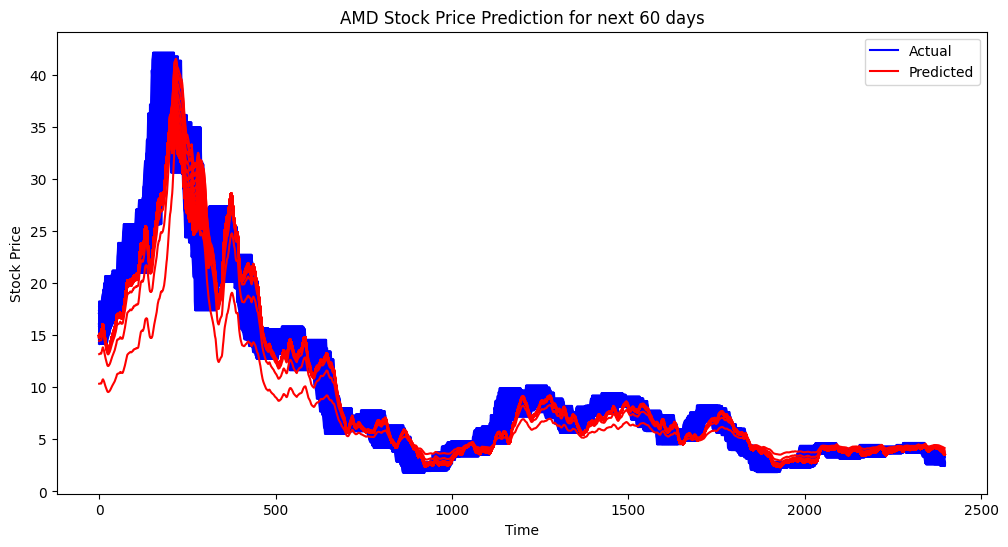

In [50]:
# Inverse transform
future_pred_test_rescaled = scaler.inverse_transform(future_pred_test.squeeze())



#actual values for next 60 days
actual_values_for_next_60_days = []

for i in range(timeSteps, len(scaled_data) - future_timeSteps):
    actual_values_for_next_60_days.append(scaled_data[i:i+future_timeSteps, 0])

actual_values_for_next_60_days = np.array(actual_values_for_next_60_days)
actual_values_for_next_60_days = actual_values_for_next_60_days.reshape(actual_values_for_next_60_days.shape[0], actual_values_for_next_60_days.shape[1])

actual_values_for_next_60_days = scaler.inverse_transform(actual_values_for_next_60_days)




# Plot
plt.figure(figsize=(12, 6))
line0 = plt.plot(actual_values_for_next_60_days, color='blue')
line1 = plt.plot(future_pred_test_rescaled, color='red')
plt.title(f'{ticker.info["symbol"]} Stock Price Prediction for next {future_timeSteps} days')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(handles=[line0[0], line1[0]], labels=['Actual', 'Predicted'])

plt.show()